(1) Le but de ce projet est de déterminer le *genre musical* d'une chanson en nous basant principalement sur ses paroles. Il s'agit donc d'un cas de classification, puisque l'on cherche la 'classe' (genre musicale) à laquelle appartient une chanson et non d'un régression (extrapolation de valeurs continues).

Bien qu'en réalité le nombre de genres musicaux soit grand, voire très grand selon ce qu'on entend par 'genre', les chansons du jeu de données sont regroupées en 11 genres assez larges comme 'Hip Hop', 'Rock' etc., ce qui réduit le nombre de classes possibles et donc devrait rendre la classification plus facile.

In [ ]:
import itertools

# regular expressions
import re

# Pour la lecture du fichier csv
import requests, zipfile, io

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy

import nltk

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from sklearn.model_selection import train_test_split as tts

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import preprocessing, metrics, pipeline, tree, ensemble, naive_bayes

# Permet de décontracter les mots comme "you're" en "you are"
!pip install contractions
import contractions
import time
!pip install memory_profiler
%load_ext memory_profiler

# Pour faire le tableau comparatif des temps d'éxécution
import plotly.graph_objects as go

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Lecture des données

In [ ]:
# inspiré de https://stackoverflow.com/questions/9419162/download-returned-zip-file-from-url et https://stackoverflow.com/questions/18885175/read-a-zipped-file-as-a-pandas-dataframe

zip_file_url = "https://github.com/hiteshyalamanchili/SongGenreClassification/raw/master/dataset/english_cleaned_lyrics.zip"
r = requests.get(zip_file_url)

with zipfile.ZipFile(io.BytesIO(r.content)) as z:
   with z.open("english_cleaned_lyrics.csv") as f:
      df = pd.read_csv(f)

display(df)
display(df.info())

,Unnamed: 0,index,song,year,artist,genre,lyrics
0,0,0,ego-remix,2009,beyonce-knowles,Pop,Oh baby how you doing You know I'm gonna cut r...
1,1,1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy it's like you seem s...
2,2,2,honesty,2009,beyonce-knowles,Pop,If you search For tenderness It isn't hard to ...
3,3,3,you-are-my-rock,2009,beyonce-knowles,Pop,Oh oh oh I oh oh oh I If I wrote a book about ...
4,4,4,black-culture,2009,beyonce-knowles,Pop,Party the people the people the party it's pop...
...,...,...,...,...,...,...,...
218205,362232,362232,who-am-i-drinking-tonight,2012,edens-edge,Country,I gotta say Boy after only just a couple of da...
218206,362233,362233,liar,2012,edens-edge,Country,I helped you find her diamond ring You made me...
218207,362234,362234,last-supper,2012,edens-edge,Country,Look at the couple in the corner booth Looks a...
218208,362235,362235,christ-alone-live-in-studio,2012,edens-edge,Country,When I fly off this mortal earth And I'm measu...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218210 entries, 0 to 218209
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  218210 non-null  int64 
 1   index       218210 non-null  int64 
 2   song        218209 non-null  object
 3   year        218210 non-null  int64 
 4   artist      218210 non-null  object
 5   genre       218210 non-null  object
 6   lyrics      218210 non-null  object
dtypes: int64(3), object(4)
memory usage: 11.7+ MB


None

(2) La  base de donnée utilisée pour le projet contient des centaines de milliers de chansons et pour chacune on a le titre, l'année de parution, l'artiste le genre et les paroles (transcription).

Le nom de l'artiste n'est pas pertinent pour plusieurs raisons:

D'abord, puisque les genres musicaux utilisés sont si larges, très peu d'artistes ont des titres de plusieurs genres différents, donc connaître le genre d'une chanson d'un artiste permettrait de connaître le genre de toutes les chansons de cet artiste. 

Ensuite, comme les noms d'artistes ont très rarement un lien direct avec leur genre musical, il ne serait pas vraiment possible de généraliser à partir des données d'entraînement puisque seuls les noms d'artistes connus par l'algorithme seraient utiles à la prédiction. 

On omettra aussi le titre, qui ne contient pas assez d'informations (trop uniques).

Dans leur état brut, les paroles ne nous sont pas très utiles parce qu'elles contiennent trop d'information, n'ont pas vraiment de structure ou d'organisation et n'ont pas de standard de transcription. Les étapes de pré-traitement nécessaires seront décrites dans le bloc suivant.

# Prétraitement

(3ab, 4c) On retire les deux premières colonnes, qui sont redondantes, ainsi que les colonnes `artist` (interprète) et `song` (titre). Du reste, nous avons 2 variables explicatives. `year` correspond à la date de sortie et `lyrics` aux paroles. Ce sont respectivement des variables quantitatives discrètes et qualitatives nominales. `lyrics` est la variable dont nous allons essayer d'exploiter au maximum le potentiel en utilisant des outils/statistiqus du traitement du langage naturel comme `Term Frequency` (fréquence des mots dans chaque texte), `TF-IDF` et `Bag of words`. La variable qu'on désire prédire est `genre`. Comme on l'a déjà mentionné, Puisqu'il s'agit d'un label, nous sommes en face d'un problème de classification. Les algorithmes utilisés pour y arriver seront `Decision Tree`, `Random Forest` et `Naive Bayes`. Puisque `Decision Tree` ne prend que des valeurs numériques en entrée, nous allons devoir encoder les variables qualitatives.

In [ ]:
df.drop(list(df.columns[0:3]) + ["artist"], axis=1, inplace = True)

In [ ]:
display(df.isnull().sum())
df[df.isnull().any(axis=1)]

year      0
genre     0
lyrics    0
dtype: int64

,year,genre,lyrics


Nous avons aucune donnée manquante dans tout le tableau. Si on en avait eu, on aurait pu soit la laisser tomber, ou bien utiliser une imputation par la règle, puisqu'il suffit de chercher le titre sur le web pour trouver un attribut associé.

Intéressons-nous maintenant au nombre d'entrées qui seront nécessaires pour le modèle.

In [ ]:
display(df.value_counts(df['genre']))

genre
Rock          100053
Pop            34137
Hip-Hop        22654
Metal          21210
Country        14158
Jazz            7310
Electronic      6942
Other           3786
R&B             3336
Indie           2935
Folk            1689
dtype: int64

Le nombre de chansons des différents genres varie beaucoup, quelques uns en ont beaucoup plus que d'autres, particulièrement Rock.

Si on entraîne un modèle sur ces données, on risquerait d'avoir un gros biais pour ces genres. On devrait donc rendre le set plus équilibré. En effet, on trouve à l'entrée de *Downsampling* du "Machine Learning Glossary" de *Google*:

```
[...]
For example, in a class-imbalanced dataset, models tend to learn a lot about
the majority class and not enough about the minority class. Downsampling helps
balance the amount of training on the majority and minority classes.
```

Le jeu de données est trop volumineux pour créer le modèle. On va donc se limiter à environ 1/10 de celui-ci. Nous avons un total d'environ 218 000 entrées, ce qui veut dire qu'on utiliserait environ 21 000 entrées. Si nous voulons avoir une représentation égale de chaque genre alors il faudrait environ 21000/11 genres, donc environ 1900 chanson par genre. `Folks` est la catégorie en ayant le moins avec 1689 donc c'est le maximum que nous allons utiliser pour que les genres soient égalements représentés.

**Note à posteriori**: en raison du temps de calcul important, on a réduit la taille à $800*11 = 8 800$ individus.

In [ ]:
n_samples = 800

df_sample = df.groupby('genre').sample(n_samples, random_state = 17)

#Test réduire nombre de classe

df_sample = df_sample[df_sample['genre'] != 'Folk']
df_sample = df_sample[df_sample['genre'] != 'Pop']
df_sample = df_sample[df_sample['genre'] != 'Rock']
df_sample = df_sample[df_sample['genre'] != 'Electronic']

print(df_sample.value_counts(df['genre']))

genre
R&B        800
Other      800
Metal      800
Jazz       800
Indie      800
Hip-Hop    800
Country    800
dtype: int64


# Tranformations du vecteur `lyrics` vers une représentation numérique

## Partie commune
Pour tous les algorithmes, il est nécessaire de fragmenter les phrases en liste de mots, de retirer les contractions, d'enlever les `stopwords` (mots qui ne sont pas significatifs, car ils sont trop communs), etc.

La première étape consiste à tout mettre en minuscule afin de standardiser et faciliter la tâche du traitement des mots.

In [ ]:
strCols = df.select_dtypes(include='object')
df_sample[strCols.columns] = strCols.applymap(lambda string: string.lower())
display(df_sample)

#Pour simplifier la manipulation
target = df_sample["genre"]

,year,genre,lyrics
77428,2006,country,dolly parton we sang a love song the day that...
95893,2007,country,you say you love me and its inviting to go whe...
37816,2007,country,we're gonna hold on we're gonna hold on we're...
39737,2007,country,i heard the bells on christmas day their old f...
190428,2008,country,there stands the glass that will ease all my p...
...,...,...,...
160090,2006,r&b,you pay your money to get in you're ready for ...
29235,2008,r&b,the water turned black and it's just getting d...
114037,1985,r&b,doo doo doo doo doo doo mmm dooby dooby doo do...
17452,2008,r&b,well i'm trying lord to be full of your convic...


Dans le fragment de code suivant, on *tokenize* les mots de chaque chanson, qui a préalablement été "corrigée" pour enlever les contractions.

In [ ]:
df_sample['tokenized'] = df_sample["lyrics"].apply(lambda l: nltk.word_tokenize(contractions.fix(l)))

Avant de poursuivre, nous allons en profiter pour ajouter une variable explicative: le nombre de mots dans une chanson. En effet, peut-être que certains genres de musiques sont généralement plus courts; on peut penser au country qui raconte des histoires, alors que le jazz est davantage orienté vers la mélodie.

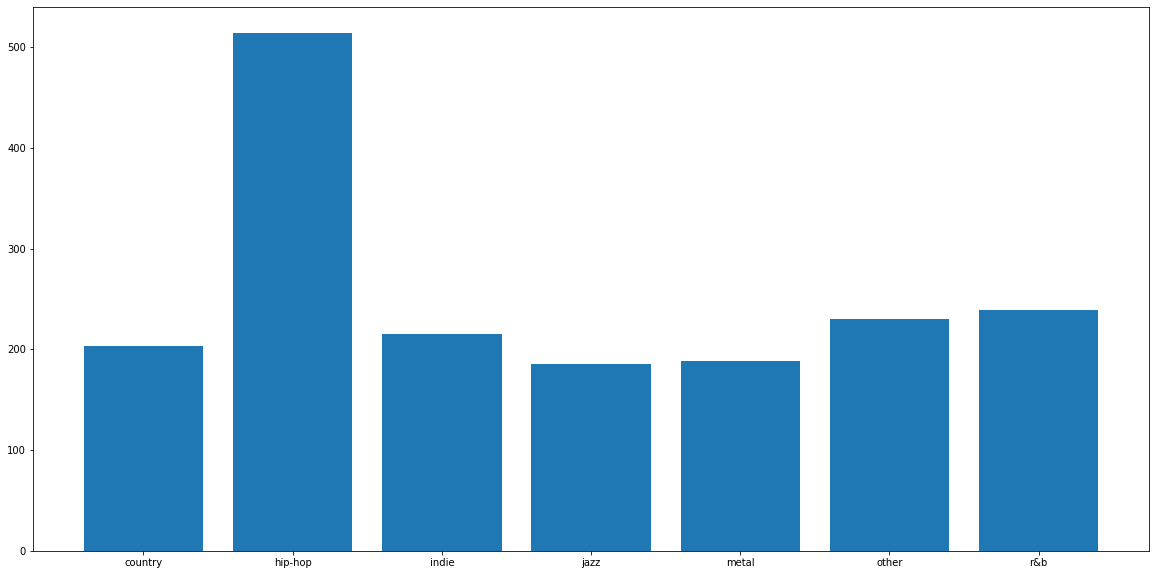

In [ ]:
df_sample["length"] = df_sample["tokenized"].apply(len)

pivoted = df_sample.pivot_table(columns="genre", values="length", aggfunc="mean")

plt.figure(figsize=(20,10))
plt.bar(x = pivoted.columns, height=pivoted.loc["length"].values)
plt.show()

Il semble effectivement avoir une différence. En particulier, cette variable est  très discriminante pour le style `hip-hop`.

Nous avons maintenant une liste de mots non contractés. Maintenant, nous allons essayer de repérer des mots aberrants comme "aaaaaaaaaaaaaaaaaaaaaaaaaaaah".

In [ ]:
words_lengths = df_sample['tokenized'].apply(lambda array : list(map(len, array))).explode()

freq = words_lengths.value_counts(sort=False)

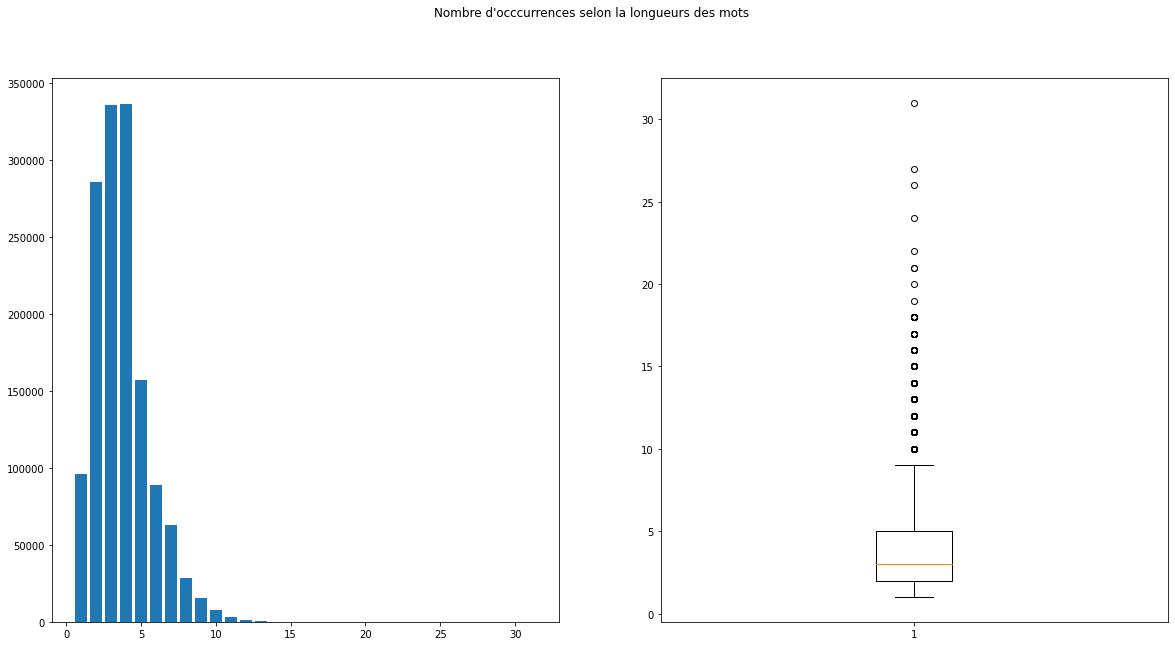

In [ ]:
plt.figure(figsize=(20,10))
plt.suptitle("Nombre d'occcurrences selon la longueurs des mots")

plt.subplot(1,2,1)
plt.bar(x = freq.index ,height = freq)

plt.subplot(1,2,2)
plt.boxplot(words_lengths)

plt.show()

In [ ]:
print("coefficient d'asymétrie:",words_lengths.skew())

coefficient d'asymétrie: 1.0763494600713674


Nous avons une distribution légèrement asymétrique à gauche, et c'est probablement lié aux données aberrantes. D'ailleurs, on peut constater sur le boxplot que certains mots ont une longueur avoisinant les 50 lettres!


In [ ]:
# inspiré de https://stackoverflow.com/questions/10072744/remove-repeating-characters-from-words

# itertools.groupby(string) retourne une liste de tuples dont le 2e élément est un itérateur contenant les caractères identiques groupés
# Donc si une lettre est présente plus de 2 fois, alors on retient le mot
stretched = df_sample['tokenized'].apply(lambda array : [word for word in array if any((len(list(s))>2 for _, s in itertools.groupby(word)))])
                                         
stretched = stretched.explode().value_counts()

print(stretched.head(50),"\n")
for word in stretched.index:
  print(word)

oooh              100
mmm                68
ooo                54
ohhh               27
ooooo              22
ayyy               16
000                14
ooooh              13
ahhh               12
oooo               11
2000               10
ohhhh              10
oooooh              9
yeaahhhhh           9
kneeewww            8
ooooooh             8
hmmm                7
oooohhh             7
1999                7
vrrroooommm         6
oooooo              6
baaaaaaaaaaimp      6
ooohhh              6
aaah                6
uhhh                6
eee                 6
aaaaoo              6
ohhhhh              6
iii                 5
ahhhh               5
hmmmm               5
nooo                5
mmmmh               5
mmmm                5
shhh                4
ahhhhh              4
ehhhh               4
whaaaaat            4
ohhhhhh             4
dooo                4
woooh               4
metaaaal            4
yeahhh              4
666                 4
dooown              4
aaaahhhhhh

On aurait pu utiliser la librairie spellchecker qui corrige les mots comme "haappyy" (qui est lui-même une réduction de "hhhaaaapppppyyyy" après avoir été réduit avec REGEX tel quel s'il contient plus de 2 lettres identiques consécutives, alors ce nombre de lettres est réduit à 2) en "happy". Par contre, à regarder la liste des mots ayant plus de 3 lettres identiques consécutives (résultat d'éxécution caché), ça semble assez négligeable pour ce que ça apporterait. Et en fait, 95% sont des "noise words", donc nous allons tout simplement les "filter out" avec le reste.

Après ce nettoyage, on devrait avoir une courbe qui s'apparente davantage à la gaussienne. Par contre, même dans ce cas, puisqu'il s'agit de mots, il ne semble pas judicieux de couper tous les mots ayant une longueur telle que son écart-type est supérieur à un certain seuil. En prenant comme hypothèse qu'il s'agit de paroles de chansons et que les mots utilisés sont généralement courts, on pourrait décider, en tenant compte des graphiques obtenus, de fixer un seuil à environ 15 lettres, mais ça reseterait arbitraire, surtout si l'on tient compte de la Loi de Zipf qui stipule que la fréquence d'apparition des mots a une distribution similaire à la fonction $$\frac {c} {x}\rightarrow \left (\frac {\mbox{fréq_mot}_i} {\mbox{total}}\right )$$Si nous mettons cela en lien avec la théorie de l'information de Claude Shanon, alors il est probable que les mots les plus utilisés soient aussi les plus courts (l'encodage d'un concept sémantique dans un son ou un mot est généralement proportionnel à son poids sémantique; un mot comme "de" est sémantiquement pauvre, mais court en raison de sa fréquence, alors qu'un mot plus spécifique comme "parachutiste" contient plus d'information (racine, affixes, etc.)). De ce fait, les mots les plus intéressants sont probablement les plus longs car ils véhiculent davantage d'information spécifique. En prenant cela en considération, nous allons opter pour un intervalle [3, 20].

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')

df_sample['tokenized'] = df_sample['tokenized'].apply(lambda array : [word for word in array if all([word not in stopwords
                                                                                                   , len(word) in range(3,20)
                                                                                                   , word.isalpha()
                                                                                                   , all((len(list(s))<3 for _, s in itertools.groupby(word)))])])

Ici on peut utiliser le *stemming* ou le *lemmatizing*, deux techniques similaires qui permettent de transformer un mot en son 'unité de base' ou sa racine, pour ignorer toutes les formes conjuguées possibles. Ainsi, on réduit le nombre total de tokens différents et on conserve le sens des mots, ce qui devrait aider la classification.

Le *stemming* est entièrement 'algorithmique' et ne tient compte que de l'orthographe donc on peut obtenir des racines qui n'ont pas vraiment de sens, ou regrouper plusieurs mots qui n'ont pas de liens, comme 'universelle' et 'université' en 'univers'. Cependant, cette technique devrait être la plus rapide.

Le *lemmatizing* tient compte des règles linguistiques et du sens même des mots, en ne retournant que des mots qui 'existent' ou sont dans le dictionnaire, donc on ne devrait pas avoir de mots qui n'ont pas de liens sous une même racine, et aucune racine n'ayant pas de sens. Cependant ce processus est plus long et couteux, mais permet plus de précision.

On utilisera donc le *lemmatizing*.

In [ ]:
lemmatizer = WordNetLemmatizer()

# inspiré de "https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python"
conversion_table = dict(zip(list("JVNR"), [wordnet.ADJ,wordnet.VERB, wordnet.NOUN, wordnet.ADV]))
tagged = nltk.tag.pos_tag_sents(df_sample["tokenized"])

df_sample['lemmatized'] = list(map(lambda sentence: [lemmatizer.lemmatize(word, conversion_table.get(cat[0], wordnet.NOUN)) for word, cat in sentence], tagged))

display(df_sample)
df_sample.drop(columns=['tokenized'], inplace=True)

,year,genre,lyrics,tokenized,length,lemmatized
77428,2006,country,dolly parton we sang a love song the day that...,"[dolly, parton, sang, love, song, day, met, th...",380,"[dolly, parton, sang, love, song, day, meet, t..."
95893,2007,country,you say you love me and its inviting to go whe...,"[say, love, inviting, life, exciting, raised, ...",204,"[say, love, invite, life, excite, raise, count..."
37816,2007,country,we're gonna hold on we're gonna hold on we're...,"[going, hold, going, hold, going, hold, life, ...",88,"[go, hold, go, hold, go, hold, life, rough, so..."
39737,2007,country,i heard the bells on christmas day their old f...,"[heard, bells, christmas, day, old, familiar, ...",112,"[heard, bell, christmas, day, old, familiar, c..."
190428,2008,country,there stands the glass that will ease all my p...,"[stands, glass, ease, pain, settle, brain, fir...",94,"[stand, glass, ease, pain, settle, brain, firs..."
...,...,...,...,...,...,...
160090,2006,r&b,you pay your money to get in you're ready for ...,"[pay, money, get, ready, fun, get, afraid, get...",126,"[pay, money, get, ready, fun, get, afraid, get..."
29235,2008,r&b,the water turned black and it's just getting d...,"[water, turned, black, getting, darker, afraid...",391,"[water, turn, black, get, darker, afraid, afra..."
114037,1985,r&b,doo doo doo doo doo doo mmm dooby dooby doo do...,"[doo, doo, doo, doo, doo, doo, dooby, dooby, d...",411,"[doo, doo, doo, doo, doo, doo, dooby, dooby, d..."
17452,2008,r&b,well i'm trying lord to be full of your convic...,"[well, trying, lord, full, conviction, sometim...",222,"[well, try, lord, full, conviction, sometime, ..."


`WordNetLemmatizer().lemmatize()`prend l'argument `pos` en paramètre. Il est requis pour déterminer à quelle groupe un mot appartient (nom, adjectif, verbe, adverbe). Ainsi, on n'a pas le choix d'utiliser la fonction `pos_tag_sents` qui permet d'associer à chaque mot le groupe auquel il appartient. Cette fonction prend beaucoup de temps à exécuter, par contre, elle reste plus rapide que la fonction `pos_tag`. En effet, dans la documentation de `pos_tag`:
```
Use `pos_tag_sents()` for efficient tagging of more than one sentence.
```

**Note**: on utilise seulement 4 catégories, car `pos` n'accepte que les 4 susmentionnées, donc les mots qui ont des catégories en dehors de celles-là sont réassignés à la catégorie `NOUN`.

Enfin, On retransforme chaque liste de string en un seul string pour appliquer les 'Vectorizer'.

In [ ]:
def list_to_str(text):
    return ' '.join(e for e in text)

df_sample['lemmas'] = df_sample['lemmatized'].apply(list_to_str)

df_sample.drop(columns=['lemmatized'], inplace=True)

## Bag of Words (BoW)

Première représentation numérique des paroles. Pour chaque chanson on crée un vecteur dont les composantes sont les occurences dans la chansons de chaque mot du 'vocabulaire' du corpus qui est l'ensemble des chansons.

In [ ]:
#Création du bag of words avec CountVectorizer

count_vect = CountVectorizer(lowercase=False, ngram_range=(1,1))
counts = count_vect.fit_transform(df_sample['lemmas'])

## Term Frequency (TF)

Cette mesure indique à quel point chaque token (ou mot) est fréquent dans les textes, relativement à la longueur des textes. Si un token particulier représente un pourcentage élevé de tous les tokens d'une chanson, alors celui-ci est peut-être bien "représentatif" de la chanson, ou y est bien spécifique.

In [ ]:
#Sommes des colonnes de la matrice counts, compte le nombre total d'occurences 
#pour calculer les term frequencies.

sums = np.sum(counts, axis=0)

tfs = scipy.sparse.csr.csr_matrix(counts/sums)

Pour une amélioration très importante du temps de fit et prediction du *Random Forest*, on va utiliser une version *sparse* de la matrice des *Term Frequencies*. On passe d'un temps de calcul, pour `.fit()` avec *Random forest*, de 1m30s à 30s.

## Term Frequency - Inverse Document Frequency (TF-IDF).


Cette mesure plus complexe utilise aussi le term frequency calculé précedemment, mais le multiplie ensuite par l' *inverse document frequency*, qui indique dans quelle fraction de tous les documents un terme se trouve. 

Ainsi, le tf-idf représente l'importance d'un token contenu dans un document (ici les paroles d'une chanson) relativement au corpus entier.

On suppose que cette mesure devrait être meilleure que la term frequency seule pour la classification.

In [ ]:
#Même logique que pour les tfs mais ici le vectorizer fais tous les calculs

tfidf_vectorizer = TfidfVectorizer(lowercase=False,ngram_range=(1,1)) 
tfidfs = tfidf_vectorizer.fit_transform(df_sample['lemmas'])

print(tfidf_vectorizer)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=False, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)


Par défaut, `norm="l2"`. C'est un traitement important à faire quand on a des features qui sont équivalents. Ainsi, les chanson plus courtes ne sont pas pénalisées vis-à-vis des chansons plus longues; le nombre de mots dans une chanson plus longue est plus grand que celui dans les chansons courtes.

$$\|\vec x\|_2 = \sqrt{x_1^2+x_2^2+ \dots + x_n^2}$$

Donc pour avoir $\|x\|_2 = 1$, il suffit de diviser $\vec x$ par $\|\vec x\|$.

# Préparation des classificateurs

Pour *Naive Bayes*, on utilisera `MultinomialNB()` avec *Bag of Words* et *TF-IDF* puisque les vecteurs contiennent des valeurs entières (voir plus bas pour *TF-IDF*) et `GaussianNB()` pour la représentation numériques *Term Frequency* qui contient des valeurs continues.

In [ ]:
dt_classifier = tree.DecisionTreeClassifier(random_state=0)
rf_classifier = ensemble.RandomForestClassifier(random_state=0)
gnb_classifier = naive_bayes.GaussianNB()
mnb_classifier = naive_bayes.MultinomialNB(alpha=0.5)

Pour `MultinomialNB`, le paramètre `alpha` est égal à 1.0 par défaut, mais il est suggérer de tester différentes valeurs. Après plusieurs essais, 0.5 semble donner dans les meilleurs résultats.

# (4ab) Bag of Words

## (3c) Séparation en datasets d'entrainement et de test

In [ ]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = tts(counts, target, test_size=0.2, random_state = 0)

## Decision Tree

In [ ]:
t1 = time.process_time()

%memit
dt_classifier.fit(X_train_bow, y_train_bow)

t_bw_dt_fit = (time.process_time()-t1)

t2 = time.process_time()

%memit
dt_pred_bow = dt_classifier.predict(X_test_bow)

t_bw_dt_pred = (time.process_time()-t2)
bw_dt_acc= dt_classifier.score(X_test_bow, y_test_bow).round(2)

peak memory: 3296.40 MiB, increment: 0.42 MiB
peak memory: 3298.78 MiB, increment: 0.00 MiB


Le *Decision Tree* n'est pas très bon en *NLP*, puisque peu de *labels* partagent les même *features*, ce qui rend difficile de trouver une bonne hiérarchie de noeuds.

## Random Forest

In [ ]:
t1 = time.process_time()

%memit
rf_classifier.fit(X_train_bow, y_train_bow)

t_bw_rf_fit = time.process_time() - t1
t2 = time.process_time()

%memit
rf_pred_bow = rf_classifier.predict(X_test_bow)

t_bw_rf_pred = time.process_time()-t2
bw_rf_acc = metrics.accuracy_score(y_test_bow, rf_pred_bow).round(3)

peak memory: 3298.86 MiB, increment: 0.00 MiB
peak memory: 3324.52 MiB, increment: 0.00 MiB


*On* remarque que l'accuracy s'est améliorée, mais l'apprentissage prend plus de temps en raison du fait qu'un Random Forest est une collection de Decision Tree. La mémoire utilisée est comparable à l'algorithme précédent.

## Naive Bayes

In [ ]:
t1 = time.process_time()

#%memit
mnb_classifier.fit(X_train_bow, y_train_bow) # .toarray() car `dense numpy array is required`  .toarray()

t_bw_nb_fit = time.process_time() -t1

#%memit
mnb_pred_bow = mnb_classifier.predict(X_test_bow)#ici

t_bw_nb_pred = time.process_time()-(t1+t_bw_nb_fit)
bw_nb_acc = metrics.accuracy_score(y_test_bow, mnb_pred_bow).round(3)

In [ ]:
t_bw_nb_fit

0.043601079999987746

Meilleure performance obtenue jusqu'à présent. Le seul problème est le fait que l'algorithme utilise beaucoup de ressource (temps de calcul, mémoire).

# (4ab) Term Frequency

Pour la comparaison détaillée du reste des algorithmes, voir le tableau à la fin.

## (3c) Séparation en datasets d'entrainement et de test

In [ ]:
X_train_tf, X_test_tf,y_train_tf, y_test_tf = tts(tfs, target, test_size =0.2, random_state=0)

## Decision Tree

In [ ]:
t1 = time.process_time()

%memit
dt_classifier.fit(X_train_tf, y_train_tf)

t_tf_dt_fit = time.process_time()-t1
t2 = time.process_time()

%memit
dt_pred_tf = dt_classifier.predict(X_test_tf)

t_tf_dt_pred = time.process_time()-t2

tf_dt_acc =dt_classifier.score(X_test_tf, y_test_tf).round(3)


peak memory: 3324.82 MiB, increment: 0.00 MiB
peak memory: 3324.83 MiB, increment: 0.00 MiB


## Random Forest

In [ ]:
t1 = time.process_time()

%memit
rf_classifier.fit(X_train_tf, y_train_tf)
t_tf_rf_fit = time.process_time()-t1

%memit
rf_pred_tf = rf_classifier.predict(X_test_tf)
t_tf_rf_pred = time.process_time()-(t1+t_tf_rf_fit)

tf_rf_acc=  metrics.accuracy_score(y_test_tf,rf_pred_tf).round(2)

peak memory: 3324.83 MiB, increment: 0.00 MiB
peak memory: 3332.45 MiB, increment: 0.00 MiB


## Naive Bayes

In [ ]:
t1 = time.process_time()

%memit
gnb_classifier.fit(X_train_tf.toarray(), y_train_tf)
t_tf_nb_fit = time.process_time()-t1

%memit
gnb_pred_tf = gnb_classifier.predict(X_test_tf.toarray())

t_tf_nb_pred = time.process_time()-(t1+t_tf_nb_fit)

tf_nb_acc = metrics.accuracy_score(y_test_tf, gnb_pred_tf).round(3)

peak memory: 3332.45 MiB, increment: 0.00 MiB
peak memory: 3332.46 MiB, increment: 0.00 MiB


# (4ab) Term Frequency - Inverse Document Frequency

Avec cette méthode, les algorithmes utilisent beaucoup plus de mémoire.

## (3c) Séparation en datasets d'entrainement et de test

In [ ]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = tts(tfidfs, target.tolist(), test_size =0.2, random_state = 0)

## Decision Tree

In [ ]:
t1 = time.process_time()

%memit
dt_classifier.fit(X_train_tfidf, y_train_tfidf)

t_idf_dt_fit = time.process_time()-t1

%memit
dt_pred_tfidf = dt_classifier.predict(X_test_tfidf)

t_idf_dt_pred = time.process_time()-(t1+t_idf_dt_fit)

idf_dt_acc = metrics.accuracy_score(y_test_tfidf,dt_pred_tfidf).round(3)

peak memory: 3332.52 MiB, increment: 0.00 MiB
peak memory: 3332.56 MiB, increment: 0.02 MiB


## Random Forest

In [ ]:
t1 = time.process_time()

%memit
rf_classifier.fit(X_train_tfidf, y_train_tfidf)

t_idf_rf_fit = time.process_time()-t1

%memit
rf_pred_tfidf = rf_classifier.predict(X_test_tfidf)

t_idf_rf_pred = time.process_time()-(t1+t_idf_rf_fit)

idf_rf_acc = metrics.accuracy_score(y_test_tfidf, rf_pred_tfidf).round(3)

peak memory: 3332.56 MiB, increment: 0.00 MiB
peak memory: 3332.57 MiB, increment: 0.00 MiB


## Naive Bayes

In [ ]:
t1 = time.process_time()

%memit
mnb_classifier.fit(X_train_tfidf.todense(), y_train_tfidf)

t_idf_nb_fit = time.process_time()-t1

%memit
gnb_pred_tfidf = mnb_classifier.predict(X_test_tfidf.todense())

t_idf_nb_pred = time.process_time()-(t1+t_idf_nb_fit)

idf_nb_acc = metrics.accuracy_score(y_test_tfidf, gnb_pred_tfidf).round(3)

peak memory: 3332.57 MiB, increment: 0.00 MiB
peak memory: 3336.66 MiB, increment: 0.16 MiB


Techniquement, `GaussianNB` devrait être utilisé puisque le jeu de données contient des valeurs continues, par contre, selon la documentation de `MultinomialNB`: 
```
The multinomial Naive Bayes classifier is suitable for classification with
discrete features (e.g., word counts for text classification). The
multinomial distribution normally requires integer feature counts. However,
in practice, fractional counts such as tf-idf may also work.
 ```

 Et en effet, le score obtenu est meilleur en utilisant `MultinomialNB`. On passe d'environ $0.24$ (et un temps d'exécution de 6.2s) à $0.323$ en 2.4s.

# Prise en charge des prédicteurs `year` et `length`
Ces deux paramètres nous semblent intéressants, car il est connu que chaque époque a eu un genre musical surreprésenté en fonction des modes et des tendences. C'est d'ailleurs une donnée qui se vérifie empiriquement. Pour ce qui est de la longueur des paroles, nous en avons déjà parlé un peu plus haut.

Les deux meilleures performance ont été obtenues avec **Naive Bayes** et **Random Forest**. On fera donc 2 modèles:
- *Random Forest* avec *TF-IDF*;
- *Naive Bayes* avec *BoW*.

On doit normaliser pour ne pas qu'il y ait une prédominance de `year`et `length`.

In [ ]:
scaler = preprocessing.MinMaxScaler()

In [ ]:
X = tfidfs.toarray()

X = np.array(list(map(lambda r, y, l: np.append(r, [y,l]), X, df_sample["year"], df_sample["length"])))

X_train_tfidf_mod, X_test_tfidf_mod, y_train_tfidf_mod, y_test_tfidf_mod = tts(X, target, test_size =0.2, random_state = 0)

X_train_tfidf_mod[:,X_train_tfidf_mod.shape[1]-2:X_train_tfidf_mod.shape[1]] = scaler.fit_transform(
    X_train_tfidf_mod[:,X_train_tfidf_mod.shape[1]-2:X_train_tfidf_mod.shape[1]])
X_test_tfidf_mod[:,X_test_tfidf_mod.shape[1]-2:X_test_tfidf_mod.shape[1]] = scaler.transform(
    X_test_tfidf_mod[:,X_test_tfidf_mod.shape[1]-2:X_test_tfidf_mod.shape[1]])

t1 = time.process_time()

#%memit
rf_classifier.fit(X_train_tfidf_mod, y_train_tfidf_mod)
t_idf_extra_fit = time.process_time()-t1

#%memit
rf_pred_tfidf_mod = rf_classifier.predict(X_test_tfidf_mod)
t_idf_extra_pred = time.process_time()-(t1+t_idf_extra_fit)

accu_idf_extra = metrics.accuracy_score(y_test_tfidf_mod, rf_pred_tfidf_mod).round(3)

In [ ]:
X = counts.toarray()
X = np.array(list(map(lambda r, y, l: np.append(r, [y,l]), X, df_sample["year"], df_sample["length"])),dtype='float64')

X_train_bow_mod, X_test_bow_mod, y_train_bow_mod, y_test_bow_mod = tts(X, target, test_size =0.2, random_state = 0)

X_train_bow_mod[:,X_train_bow_mod.shape[1]-2:X_train_bow_mod.shape[1]] = scaler.fit_transform(
    X_train_bow_mod[:,X_train_bow_mod.shape[1]-2:X_train_bow_mod.shape[1]])
X_test_bow_mod[:,X_test_bow_mod.shape[1]-2:X_test_bow_mod.shape[1]] = scaler.transform(
    X_test_bow_mod[:,X_test_bow_mod.shape[1]-2:X_test_bow_mod.shape[1]])

t1 = time.process_time()


mnb_classifier.fit(X_train_bow_mod, y_train_bow_mod)
t_bow_extra_fit = time.process_time()-t1

%memit
mnb_pred_bow_mod = mnb_classifier.predict(X_test_bow_mod)
t_bow_extra_pred = time.process_time()-(t1+t_bow_extra_fit)

accu_bow_extra = metrics.accuracy_score(y_test_bow_mod, mnb_pred_bow_mod).round(3)


peak memory: 5541.23 MiB, increment: -0.04 MiB


Ce qui est remarquable, c'est qu'en ajoutant deux prédicteurs, le temps de calcul fond à 6 secondes. C'est un contraste important avec le modèle sans ces 2 variables (1m30s). Du reste, la performance est similaire.

En somme, les scores obtenus sont plutôt bas, même si les deux prédicteurs supplémentaires semblent aider. Toutefois, si l'on tient compte du fait qu'il y a 11 genres, alors une réponse complètement aléatoire devrait donner un score d'environ 9%. Or, dans les simulations que nous avons faites, on a pu atteindre une accuracy frôlant les 40%, ce qui est excellent compte tenu de la tâche. En effet, il semble beaucoup plus complexe de dire à quel genre une chanson appartient en fonction du vocabulaire qu'il contient en comparaison avec d'autre classifications, comme le sport ou la cuisine. C'est que l'ensemble du vocabulaire est beaucoup moins pointu (narrow) que pour catégoriser des recettes, par exemple. Des chansons ayant un champ lexical tournant autour de l'amour existent dans environ tous les styles et c'est d'ailleurs probablement l'un des thèmes les plus récurrent, mais c'est un point qui serait à vérifier. Quoi qu'il en soit, c'est une tâche qui resterait difficile à faire même pour un humain.

Une chose à laquelle nous nous attendions pas est le fait que la taille d'échantillon pour développer les modèles a eu un impact très marginal sur la force du modèle. En effet, le fait de passer d'un jeu de données de $11*150$ entrées à $11*1689$ n'a fait varier l'accuracy favorablement que de 2-3 points de pourcentage. On aurait pu comparer sur un graphique l'accuracy en fonction de la taille de l'échantillon, mais le temps de calcul devient rapidement très long.

Note bonus: nous avons fait l'essai de classifier le genre uniquement selon l'année et le nombre de mots dans la chanson avec *Random Forest* et nous avons obtenu un score de .2, ce qui est mieux que le hasard et ce qui est, en fait, aussi mieux que certains résultats obtenus précédemment!

# (5) Visualisation de la performance avec la matrice de confusion

Pour cette dernière partie, on va utiliser les meilleurs résultats que nous avons obtenus (*Naive Bayes* et *Random Forest* avec les prédicteurs supplémentaires).

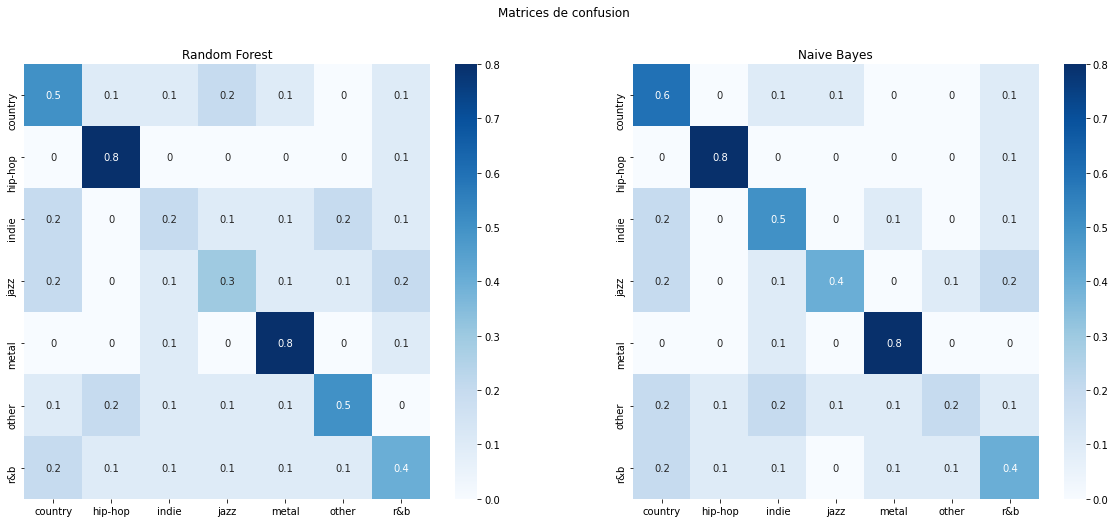

In [ ]:
cf_rf = metrics.confusion_matrix(y_test_tfidf_mod, rf_pred_tfidf_mod, normalize="true")
cf_nb = metrics.confusion_matrix(y_test_bow_mod, mnb_pred_bow_mod, normalize="true")

plt.figure(figsize=(20,8))
plt.suptitle("Matrices de confusion")

plt.subplot(1,2,1)
sns.heatmap(cf_rf.round(1), annot=True, xticklabels=target.unique(), yticklabels=target.unique(), cmap="Blues")
plt.title("Random Forest")

plt.subplot(1,2,2)
sns.heatmap(cf_nb.round(1), annot=True, xticklabels=target.unique(), yticklabels=target.unique(), cmap="Blues")
plt.title("Naive Bayes")

plt.show()

On voit que ce ne sont pas tout à fait les mêmes genres musicaux qui sont le mieux classés. En effet, *Random Forest* arrive à bien classifier les chansons appartenant à `other`, mais ce n'est pas le cas de *Naive Bayes*. Du reste, on peut dire que les deux genres ayant eu la meilleure classification sont `hip-hop` et `metal`. On avait d'ailleurs vu, dans le diagramme de distribution, que `length` était très discriminant pour le genre `hip-hop`, où le nombre de paroles est beaucoup plus grand, en moyenne, que le reste des genres. Pourtant, les algorithmes performent aussi bien sans cette variable. 

Si l'on compare la matrice de confusion de gauche avec celle (ci-bas) obtenue par les chercheurs ayant travailler avec le même jeu de données pour développer un modèle de classification selon les paroles, on constate qu'il y a peu de similarités, mais cela est explicable par le fait qu'ils ont utilisé un algorithme de *deep learning*. D'ailleurs, ils ont pu obtenir une accuracy d'environ 62%, ce qui est pratiquement deux fois mieux que ce qu'on a pu obtenir avec le Random Forest.

 Quant aux genres les mieux classifiés avec *Deep Learning*, ce sont `Metal` et `Jazz`. Nous avons donc une catégorie en commun, mais pour les deux autres, elles ont été mal classifiées avec l'autre algorithme respectif. 

Enfin, les chansons qui ont été mal classifiées n'ont pas été toutes placées dans une catégorie "fourre-tout", à l'inverse des résultats obtenus avec le modèle de *deep learning*, où l'on peut voir que l'algorithme avait une préférence pour la catégorie `Indie`. En effet, on remarque qu'il y a des zéros pratiquement partout, hormis sur la diagonale principale et sur la dernière colonne, alors que dans le cas de nos modèle, les erreurs sont plus dispersées.

La raison qui explique un taux de classification qui n'est pas de l'ordre du hasard se situe probablement dans le fait que l'algorithme classifie très bien certain genres, mais est médiocre pour le reste.

Bref, on aurait probablement un meilleur taux de classification si l'on utilisait la mélodie plutôt que les paroles comme prédicteur.

![test](https://raw.githubusercontent.com/philipGaudreau/apprentissageSupervise/main/cf.png)

$\boxed{\color{green}{\mbox{BONUS}}} \rightarrow$ *Just for fun*

In [ ]:



from sklearn import svm

SVM = svm.SVC()
SVM.fit(X_train_tfidf,y_train_tfidf)

predictions_SVM = SVM.predict(X_test_tfidf)

print("SVM Accuracy Score -> ",metrics.accuracy_score(predictions_SVM, y_test_tfidf).round(3))


SVM Accuracy Score ->  0.492


# (4d) Run times

In [ ]:
#temps dexec du DT
times_dt_fit = [t_bw_dt_fit, t_tf_dt_fit, t_idf_dt_fit]
times_dt_pred = [t_bw_dt_pred,t_tf_dt_pred, t_idf_dt_pred]

#random forest
times_rf_fit = [t_bw_rf_fit, t_tf_rf_fit, t_idf_rf_fit]
times_rf_pred = [t_bw_rf_pred,t_tf_rf_pred, t_idf_rf_pred]

#naive bayes
times_nb_fit = [t_bw_nb_fit, t_tf_nb_fit, t_idf_nb_fit]
times_nb_pred = [t_bw_nb_pred,t_tf_nb_pred, t_idf_nb_pred]

#extras
times_extra_fit = [t_idf_extra_fit, t_bow_extra_fit ]
times_extra_pred = [t_idf_extra_pred, t_bow_extra_pred]

#accuracies
accu_dt = [bw_dt_acc, tf_dt_acc, idf_dt_acc]
accu_rf = [bw_rf_acc, tf_rf_acc, idf_rf_acc]
accu_nb = [bw_nb_acc, tf_nb_acc, idf_nb_acc]
accu_extra = [accu_idf_extra, accu_bow_extra]


accu_dt = [100*acc for acc in accu_dt]
accu_rf = [100*acc for acc in accu_rf]
accu_nb = [100*acc for acc in accu_nb]
accu_extra = [100*acc for acc in accu_extra]

In [ ]:
algos = ['Decision tree BoW', 'Decision tree TF', 'Decision tree TFIDF',
         'Random forest BoW','Random forest TF','Random forest TFIDF',
         'Naive Bayes BoW','Naive Bayes TF','Naive Bayes TFIDF','RF+prédicteurs extras', 'Naive Bayes+prédicteurs extras']

times_fit = [round(elem, 3) for elem in times_dt_fit+times_rf_fit+times_nb_fit+times_extra_fit]
times_pred = [round(elem, 3) for elem in times_dt_pred+times_rf_pred+times_nb_pred+times_extra_pred]
accuracies = [round(elem, 3) for elem in accu_dt+accu_rf+accu_nb+accu_extra]

### Comparaison des temps d'entraînement et prédiction ainsi qu'accuracy des algorithmes.

In [ ]:
table = pd.DataFrame(data = np.array([algos,times_fit, times_pred, accuracies]).T).sort_values(by = 3, ascending=False).T

colonnes=['Algorithme','Temps fitting (s)', 'Temps prediction (s)', 'Accuracy (%)']

fig = go.Figure(data = [go.Table(
    header=dict(values = colonnes,
                align = 'center'),
    cells=dict(values = table,
               align = 'left')
)])

fig.show()

Comparaison des différents algorithmes utilisés et de leurs temps de fitting et prediction sur 800 échantillons par genre pour un total de 8800. 

Les temps de fitting sont ce qui change le plus, l'algorithme le plus lent (random forest sur TF-IDF avec prédicteurs extras) a pris près de 1000 fois plus de temps à s'exécuter que le plus rapide. Le temps de prédiction ne varie pas autant, variant de moins d'une seconde à environ 4 secondes.

En termes d'*accuracy*, le meilleur algorithme a environ 15 points de pourcentage de plus que le pire, soit une augmentation de près de 75%.

Les 'prédicteurs extras' utilisés deux fois sont `year` et `length`. Dans les deux cas, on voit une légère augmentation de l'accuracy par rapport au même algorithme sans ces prédicteurs. Dans le cas du *Naive Bayes*, l'augmentation est minime, soit 0.2 points de pourcentage (moins de 1% relatif) ce qui pourrait être entièrement attribuable au hasard. Le *random forest* gagne 2 points de pourcentage, soit une augmentation relative de 6%.

Qu'on tienne compte ou pas de la représentation numérique utilisée pour les données, certaines tendances ressortent du tableau. Par exemple, le *decision tree* a systématiquement une moins bonne accuracy que les deux autres algorithmes. Il était attendu que le *random forest* obtienne de meilleurs résultats puisqu'il s'agit de plusieurs *decision trees*, mais aucune telle hypothèse avait été posée pour le *naive bayes*.

D'ailleurs, le *naive bayes* semble généralement être aussi voire plus accurate que le *random forest*  tout en étant beaucoup plus rapide. En effet, avec n=800, *naive bayes* a une accuracy relative environ 7% plus élevée que le *random forest* mais s'exécute en environ 1/30e du temps, une différence énorme. 

De plus, le temps d'exécution du *random forest* augmente beaucoup plus rapidement que celui du *naive bayes* lorsque l'on augmente le nombre de samples, sans nécessairement que l'accuracy augmente beaucoup. Ainsi, le *naive* bayes semble réellement le meilleur algorithme dans notre situation.